In [1]:
import json
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
from sklearn.metrics import accuracy_score
import warnings
import logging

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

# 載入資料
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

In [2]:
tokenizer = AutoTokenizer.from_pretrained('hfl/chinese-lert-large')
model = AutoModelForQuestionAnswering.from_pretrained('hfl/chinese-lert-large')

tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.31G [00:00<?, ?B/s]

In [3]:
paragraphs = load_data('./context.json')
train_data = load_data('./train.json')
val_data = load_data('./valid.json')

In [4]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    context = [paragraphs[r] for r in examples["relevant"]]
    inputs = tokenizer(
        questions,
        context,
        max_length=512,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answer"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer_text = answers[i]['text']
        start_char = answers[i]['start']
        end_char =  start_char + len(answer_text)
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # Find the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [5]:
train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))
val_dataset = Dataset.from_pandas(pd.DataFrame(val_data))

In [6]:
# 對訓練和驗證數據進行預處理
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)

Map:   0%|          | 0/21714 [00:00<?, ? examples/s]

Map:   0%|          | 0/3009 [00:00<?, ? examples/s]

In [8]:
import os
# 禁用 wandb
os.environ["WANDB_DISABLED"] = "true"

from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

import numpy as np
from transformers import get_linear_schedule_with_warmup

def compute_metrics(pred):
    # Unpack predictions (logits for start and end positions)
    start_logits, end_logits = pred.predictions

    # Get the predicted start and end indices by applying argmax across the logits
    start_preds = np.argmax(start_logits, axis=1)
    end_preds = np.argmax(end_logits, axis=1)
    start_labels, end_labels = pred.label_ids

    exact_matches = []

    # Loop through each prediction
    for i in range(len(start_preds)):
        # Get the predicted and actual start/end positions
        start_pred = int(start_preds[i])
        end_pred = int(end_preds[i])
        start_label = start_labels[i]
        end_label = end_labels[i]
        
        # Compute Exact Match and F1 score based on the predicted and true positions
        em_score = 1 if (start_pred == start_label and end_pred == end_label) else 0

        exact_matches.append(em_score)

    return {
        "exact_match": sum(exact_matches) / len(exact_matches)  # Average exact match
    }

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",    # 改成每步評估
    save_strategy="steps",
    save_steps=800,
    eval_steps=800,
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    gradient_accumulation_steps=2,
    weight_decay=0.02,
    load_best_model_at_end=True,
    metric_for_best_model="exact_match",
    greater_is_better=True,
    save_total_limit=1,
    disable_tqdm=False,
    save_safetensors=False,
    fp16=True,  # 啟用混合精度訓練
#     optim="adafactor",
#     lr_scheduler_type="cosine", 
#     warmup_ratio=0.2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Exact Match
800,0.979700,0.595576,0.772350
1600,0.445500,0.597446,0.785975
2400,0.283400,0.537117,0.805583
3200,0.173700,0.775322,0.803257
4000,0.103800,0.791926,0.804919


TrainOutput(global_step=4071, training_loss=0.36275282751808174, metrics={'train_runtime': 12349.0047, 'train_samples_per_second': 5.275, 'train_steps_per_second': 0.33, 'total_flos': 6.048111415534387e+16, 'train_loss': 0.36275282751808174, 'epoch': 2.998895027624309})

In [9]:
trainer.evaluate()

{'eval_loss': 0.537117063999176,
 'eval_exact_match': 0.8055832502492523,
 'eval_runtime': 162.4578,
 'eval_samples_per_second': 18.522,
 'eval_steps_per_second': 2.321,
 'epoch': 2.998895027624309}

In [10]:
# 让模型中的所有参数都变成连续的
for param in model.parameters():
    if not param.is_contiguous():
        param.data = param.contiguous()

model.save_pretrained("./finetuned_qa")
tokenizer.save_pretrained("./finetuned_qa")

('./finetuned_qa/tokenizer_config.json',
 './finetuned_qa/special_tokens_map.json',
 './finetuned_qa/vocab.txt',
 './finetuned_qa/added_tokens.json',
 './finetuned_qa/tokenizer.json')

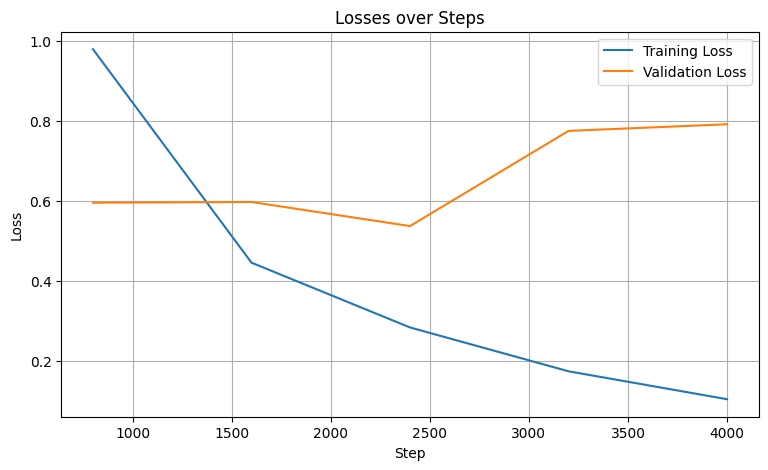

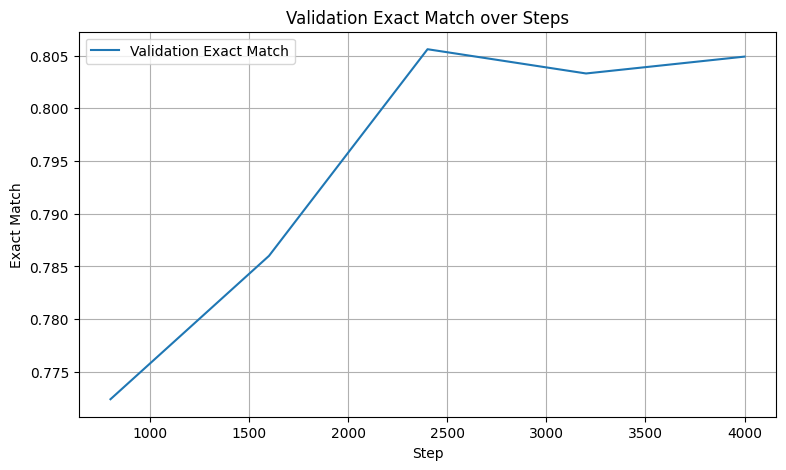

In [1]:
import matplotlib.pyplot as plt

train_losses = [0.9797, 0.4455, 0.2834, 0.1737, 0.1038]
val_losses = [0.5956, 0.5974, 0.5371, 0.7753, 0.7919]
exact_matches = [0.7724, 0.7860, 0.8056, 0.8033, 0.8049]
steps = [800, 1600, 2400, 3200, 4000]

# 畫訓練損失圖
plt.figure(figsize=(9, 5))
plt.plot(steps, train_losses, label='Training Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Losses over Steps')
plt.legend()
plt.grid(True)
plt.show()

# 畫驗證集 Exact Match 圖
plt.figure(figsize=(9, 5))
plt.plot(steps, exact_matches, label='Validation Exact Match')
plt.xlabel('Step')
plt.ylabel('Exact Match')
plt.title('Validation Exact Match over Steps')
plt.legend()
plt.grid(True)
plt.show()